In [181]:
# Initialization
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imsave, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Model, load_model
from keras.utils import to_categorical # one-hot-encoding

# Required for loss function
import math
from tensorflow.python.keras import losses

import tensorflow as tf

from unet_utilz import *

In [2]:
# Set someparameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
LABEL_CLASS = 3

MODEL_NAME = 'model-Swain-unet-aug.h5'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [6]:
# Importing data...

# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
#TRAIN_PATH = 'F:\\MA\\data\\NIH\\Ls\\20180717_161620(new_Ls)\\train\\'
TEST_PATH = 'F:\\MA\\data\\Swain_lab\\DISCO_result\\str515_GFP_006\\test\\'


# original lab dataset
# 'F:\\MA\\data\\dataset_lab\\train\\'
# L-shape dataset
# 'F:\\MA\\data\\NIH\\Ls\\20180717_161620(new_Ls)\\train\\'
# DISCO dataset
# 'F:\\MA\\data\\Swain_lab\\DISCO_result\\str515_GFP_006\\test\\'

# Get train and test IDs
#train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
test_ids = next(os.walk(TEST_PATH + 'in/'))[2]
mask_ids = next(os.walk(TEST_PATH + 'out-cell/'))[2]

# X_test: original images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
# Y_test: masks
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)
# Y_orig: original mask without one-hot encoding
#Y_orig = np.zeros((len(test_ids), 64, 64), dtype=np.uint8)
    
    
# Get and resize test images
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    img = imread(TEST_PATH + 'in/' + id_)
    X_test[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)

    
print('Getting and resizing test masks ... ')    

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    
    mask = imread(TEST_PATH + 'out-cell/' + id_)
    #Y_orig[n] = mask
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_test[n] = mask
    
    
print('Done!')

Getting and resizing test images ... 


100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 481.84it/s]


Getting and resizing test masks ... 


100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 229.79it/s]


Done!


In [66]:
# Predict on test data via UNet
model = load_model('.\\' + MODEL_NAME, custom_objects={'bce_dice_loss': bce_dice_loss, 'IoU': IoU, 'dice_loss': dice_loss})
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

173/173 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 8s 44ms/step


In [ ]:
#################################### Following blocks are used for generating result images #######################################

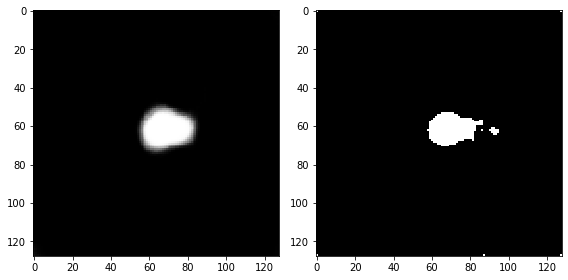

In [146]:
plt.figure(figsize=(8,4))
#plt.grid(None)
plt.subplot(121)
imshow(preds_test[1,:,:,2])

plt.subplot(122)
#plt.grid(None)
imshow(preds_test_t[1,:,:,2])
plt.show()

In [147]:
# Generate the mask wihtout one-hot-encoding 
preds_test_mask = np.zeros(shape=(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2]))

for i in range(preds_test_t.shape[0]):
    for y in range(preds_test_t.shape[1]):
        for x in range(preds_test_t.shape[2]):
            if preds_test_t[i, y, x, 1] == 1:
                preds_test_mask[i, y, x] = 1
            elif preds_test_t[i, y, x, 2] == 1:
                preds_test_mask[i, y, x] = 2
            else:
                preds_test_mask[i, y, x] = 0

137


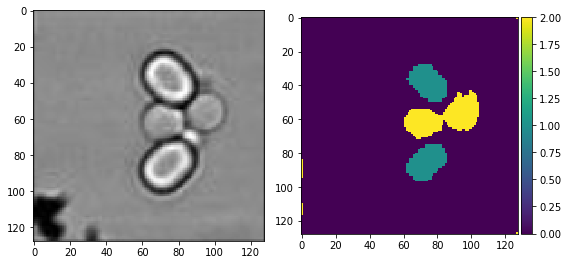

In [148]:
# Visualize the test image + the prediction masks
ix = random.randint(0, len(test_ids)-1)
#ix = 1
print(ix)

plt.figure(figsize=(8,4))
#plt.grid(None)
plt.subplot(121)
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))

#plt.grid(None)
#imshow(Y_orig[ix])
#plt.show()

plt.subplot(122)
#plt.grid(None)
imshow(np.squeeze(preds_test_mask[ix]))
plt.show()

In [149]:
# Generate the images to save
preds_res = np.zeros(shape=(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2]))

for i in range(preds_test_t.shape[0]):
    for y in range(preds_test_t.shape[1]):
        for x in range(preds_test_t.shape[2]):
            if preds_test_t[i, y, x, 1] == 1:
                preds_res[i, y, x] = 128
            elif preds_test_t[i, y, x, 2] == 1:
                preds_res[i, y, x] = 255
            else:
                preds_res[i, y, x] = 0
                
preds_res = preds_res.astype('uint8')

11


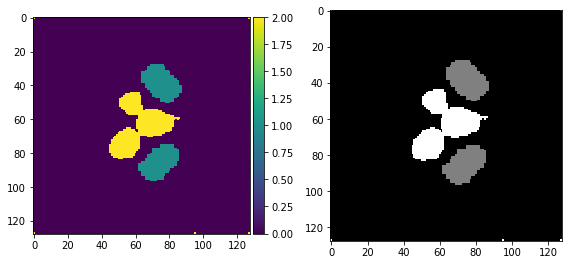

In [150]:
# Generate and save the test image + the prediction masks
#ix = random.randint(0, len(test_ids))
ix = 11
print(ix)

plt.figure(figsize=(8,4))
plt.subplot(121)
#plt.grid(None)
imshow(np.resize(preds_test_mask[ix], (128, 128)))

plt.subplot(122)
#plt.grid(None)
imshow(preds_res[ix])
plt.show()

In [151]:
################### Don't run unless you want to generate images!!!!!!! ######################
##############################################################################################
# Generate and save the test image + the prediction masks

for i, id_ in tqdm(enumerate(preds_res), total = len(preds_res)):
    imsave('.\\prediction\\' + test_ids[i].replace('jpg','png'), preds_res[i])

100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 202.81it/s]


In [ ]:
#################################### Following blocks are used for generating stats and csv ###########################################

In [201]:
IoU_score = []
class_IoU_score = []
class_f1_score = []
class_precision_score = []
class_recall_score =  []

for d in range(Y_test.shape[3]):
    class_IoU_score.append([])
    class_f1_score.append([])
    class_precision_score.append([])
    class_recall_score.append([])

for i in range(len(X_test)):
    IoU_score.append(metric_IoU(Y_test[i], preds_test_t[i]))
    for d in range(Y_test.shape[3]):
        class_IoU_score[d].append(metric_IoU(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_f1_score[d].append(metric_f1(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_precision_score[d].append(metric_precision(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_recall_score[d].append(metric_recall(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        
IoU_score = np.array(IoU_score)
class_IoU_score = np.array(class_IoU_score)
class_f1_score = np.array(class_f1_score)
class_precision_score = np.array(class_precision_score)
class_recall_score = np.array(class_recall_score)

IoU_result = pd.DataFrame(data = class_IoU_score.transpose(), columns = ['IoU_Background', 'IoU_Trap', 'IoU_Cell'])
f1_result = pd.DataFrame(data = class_f1_score.transpose(), columns = ['F1_Background', 'F1_Trap', 'F1_Cell'])
precision_result = pd.DataFrame(data = class_precision_score.transpose(), columns = ['P_Background', 'P_Trap', 'P_Cell'])
recall_result = pd.DataFrame(data = class_recall_score.transpose(), columns = ['R_Background', 'R_Trap', 'R_Cell'])

res_stat = pd.concat([IoU_result, f1_result, precision_result, recall_result], axis=1)

In [202]:
res_stat.describe().round(4)

,IoU_Background,IoU_Trap,IoU_Cell,F1_Background,F1_Trap,F1_Cell,P_Background,P_Trap,P_Cell,R_Background,R_Trap,R_Cell
count,173.0000,173.0000,173.0000,173.0000,173.0000,173.0000,173.0000,173.0000,173.0000,173.0000,173.0000,173.0000
mean,0.9580,0.5117,0.5960,0.9785,0.6766,0.7403,0.9704,0.9996,0.8670,0.9868,0.5118,0.6658
std,0.0153,0.0268,0.1042,0.0081,0.0235,0.1035,0.0092,0.0038,0.1303,0.0097,0.0269,0.0917
min,0.9022,0.4173,0.0000,0.9486,0.5888,0.0000,0.9310,0.9613,0.0000,0.9439,0.4173,0.3595
25%,0.9535,0.4915,0.5506,0.9762,0.6591,0.7102,0.9675,1.0000,0.8200,0.9835,0.4915,0.6073
50%,0.9621,0.5118,0.6061,0.9807,0.6771,0.7547,0.9720,1.0000,0.9072,0.9893,0.5118,0.6601
75%,0.9683,0.5312,0.6572,0.9839,0.6938,0.7932,0.9767,1.0000,0.9428,0.9935,0.5312,0.7229
max,0.9768,0.5726,0.7948,0.9883,0.7282,0.8857,0.9832,1.0000,0.9876,0.9988,0.5726,1.0000


In [198]:
res_stat.to_csv(path_or_buf='.\\res_stat.csv')

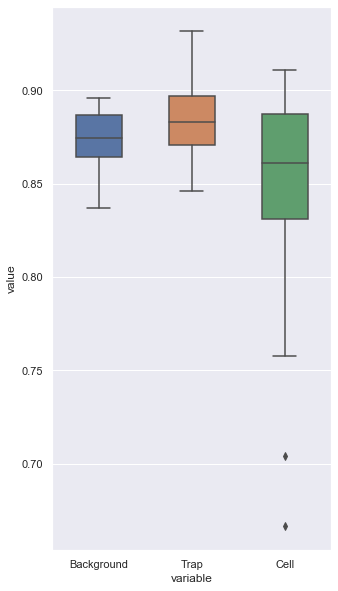

In [57]:
###################### Generate boxplot of scores ###########################

sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(IoU_result), width = 0.5)
#sns.boxplot(IoU_result)

#plt.show()
plt.savefig('IoU.png')

In [ ]:
########################### Following blocks are for evaluation of DISCO ####################################

In [98]:
PATH = 'F:\\MA\\data\\Swain_lab\\DISCO_result\\str515_GFP_006\\'
DIM_ids = next(os.walk(PATH + 'DIM_test\\'))[2]

# Decision Image from DISCO
DIM = np.zeros((len(DIM_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Getting and resizing DIMs ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(DIM_ids), total=len(DIM_ids)):
    
    img = imread(PATH + 'DIM_test\\' + id_)
    DIM[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, rescale = True)
    

Getting and resizing DIMs ... 


100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 456.34it/s]


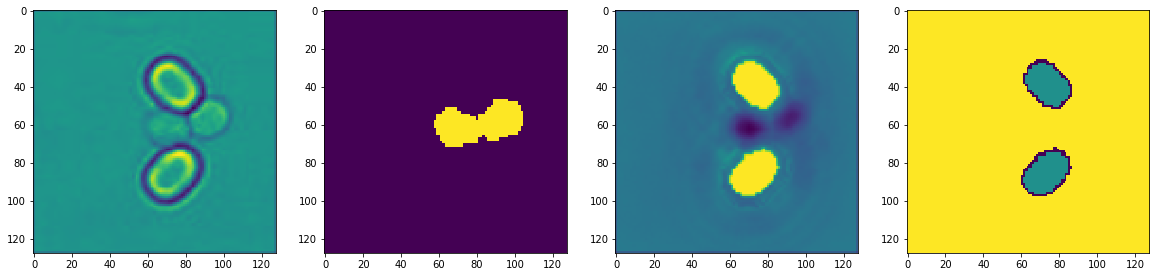

In [85]:
#ix = random.randint(0, len(DIM_ids)-1)
ix = 0

plt.figure(figsize=(20,10))
plt.subplot(141), plt.imshow(X_test[ix,:,:,0])
plt.subplot(142), plt.imshow(Y_test[ix,:,:,2]) #, plt.axis('off')
plt.subplot(143), plt.imshow(DIM[ix,:,:,0])
plt.subplot(144), plt.imshow(preds_test_mask[ix]) #, plt.axis('off')
plt.show()

In [199]:
#################### Generating DISCO prediction result will cover UNet result in preds_test_t #######################
#################### T_trap = 1, T_cell = 0.61 (Break-Even Point) #####################

T_trap = 1
T_cell = 0.375 #Break-Even Point

preds_test_t_DISCO = np.zeros(shape=(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2], preds_test_t.shape[3]))

for i in range(preds_test_t_DISCO.shape[0]):
    for y in range(preds_test_t_DISCO.shape[1]):
        for x in range(preds_test_t_DISCO.shape[2]):
            if DIM[i, y, x] == T_trap:
                # Trap
                #preds_test_t[i, y, x, 0] = 0
                preds_test_t_DISCO[i, y, x, 1] = 1
                #preds_test_t[i, y, x, 2] = 0
            elif DIM[i, y, x] < T_cell:
                # Cell
                #preds_test_t[i, y, x, 0] = 0
                #preds_test_t[i, y, x, 1] = 0
                preds_test_t_DISCO[i, y, x, 2] = 1
            else:
                # Background
                preds_test_t_DISCO[i, y, x, 0] = 1
                #preds_test_t[i, y, x, 1] = 0
                #preds_test_t[i, y, x, 2] = 0                

In [200]:
preds_test_t = preds_test_t_DISCO

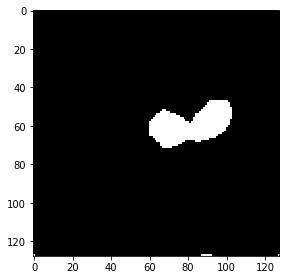

In [145]:
imshow(preds_test_t_DISCO[0,:,:,2])

In [ ]:
######################################### Following blocks are used for ROC #############################################

In [162]:
# Predict on test data via UNet
model = load_model('.\\' + MODEL_NAME, custom_objects={'bce_dice_loss': bce_dice_loss, 'IoU': IoU, 'dice_loss': dice_loss})
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

173/173 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 8s 45ms/step


In [168]:
from sklearn.metrics import roc_curve, auc # roc curve tools

ground_truth_labels_cell = Y_test[:,:,:,2].ravel() # we want to make them into vectors
ground_truth_labels_trap = Y_test[:,:,:,1].ravel()

DISCO_score_trap = DIM.ravel()/255.0 
DISCO_score_cell = 1 - DISCO_score_trap

UNet_score_trap = preds_test[:,:,:,1].ravel()
UNet_score_cell = preds_test[:,:,:,2].ravel()



DISCO_fpr_cell, DISCO_tpr_cell, _ = roc_curve(ground_truth_labels_cell,DISCO_score_cell)
DISCO_auc_cell = auc(DISCO_fpr_cell,DISCO_tpr_cell)
DISCO_fpr_trap, DISCO_tpr_trap, _ = roc_curve(ground_truth_labels_trap,DISCO_score_trap)
DISCO_auc_trap = auc(DISCO_fpr_trap,DISCO_tpr_trap)

UNet_fpr_cell, UNet_tpr_cell, _ = roc_curve(ground_truth_labels_cell,UNet_score_cell)
UNet_auc_cell = auc(UNet_fpr_cell,UNet_tpr_cell)
UNet_fpr_trap, UNet_tpr_trap, _ = roc_curve(ground_truth_labels_trap,UNet_score_trap)
UNet_auc_trap = auc(UNet_fpr_trap,UNet_tpr_trap)

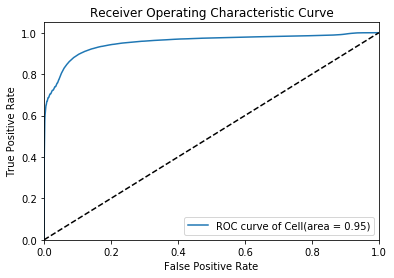

In [178]:
fig, ax = plt.subplots(1,1)
ax.figsize=(50,30)

ax.plot(DISCO_fpr_cell, DISCO_tpr_cell, label='DISCO ROC curve of Cell(area = %0.2f)' % DISCO_auc_cell)
#ax.plot(DISCO_fpr_trap, DISCO_tpr_trap, label='DISCO ROC curve of Trap(area = %0.2f)' % DISCO_auc_trap)
#ax.plot(UNet_fpr_cell, UNet_tpr_cell, label='UNet ROC curve of Cell(area = %0.2f)' % UNet_auc_cell)
#ax.plot(UNet_fpr_trap, UNet_tpr_trap, label='UNet ROC curve of Trap(area = %0.2f)' % UNet_auc_trap)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Curve')
ax.legend(loc="lower right")

plt.savefig('ROC.png')

In [ ]:
##################################### Following blocks are used for stat of CellSerpent ########################################

In [183]:
def label_to_mask_DISCO(label):
    mask = np.zeros([label.shape[0], label.shape[1]])
    
    for x in range(label.shape[0]):
        for y in range(label.shape[1]):
            if label[x,y] == 128:
                mask[x,y] = 1
            elif label[x,y] == 255:
                mask[x,y] = 2
                    
    return mask.astype('uint8')

In [190]:
PATH = 'F:\\MA\\data\\Swain_lab\\DISCO_result\\str515_GFP_006\\cellserpent_res\\'


# Get train and test IDs
RES_ids = next(os.walk(PATH))[2]


RES = np.zeros((len(RES_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)


print('Getting and resizing results ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(RES_ids), total=len(RES_ids)):
    
    mask = imread(PATH + id_)
    mask = label_to_mask_DISCO(mask)
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    RES[n] = mask
    
print('Done!')

Getting and resizing results ... 


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:05<00:00, 32.79it/s]


Done!


In [195]:
preds_test_t = RES